In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pickle

In [2]:
from problem_formulation import get_model_for_problem_formulation
from ema_workbench import MultiprocessingEvaluator, Policy
from ema_workbench.util import ema_logging
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
ema_logging.log_to_stderr(ema_logging.INFO)
problem_formulation_id = 2
dike_model, planning_steps = get_model_for_problem_formulation(problem_formulation_id)

In [4]:
def get_0_dict():
    return {l.name: 0 for l in dike_model.levers}

# Creates a Policy object from a dict and a (optional) name
def create_policy(dict1, name=None):
    return Policy(f"Policy_{name}", **dict(get_0_dict(), **dict1))

In [5]:
###all no-warning policies to reproduce preliminary model setup

#pol1w = create_policy({'0_RfR 0': 1,
#'1_RfR 0': 1,
#'2_RfR 0': 1,
#'3_RfR 0': 1,
#'4_RfR 0': 1,
#'DaysToThreat': 0,
#'A.1_Dike Increase 0': 10,
#'A.2_Dike Increase 0': 10,
#'A.3_Dike Increase 0': 10,
#'A.4_Dike Increase 0': 10,
#'A.5_Dike Increase 0': 10,},'All, no warning')

#pol3w = create_policy({'0_RfR 0': 1,
#'1_RfR 0': 1,
#'2_RfR 0': 0,
#'3_RfR 0': 1,
#'4_RfR 0': 0,
#'EWS_DaysToThreat': 0,
#'A.1_DikeIncrease 0': 0,
#'A.2_DikeIncrease 0': 0,
#'A.3_DikeIncrease 0': 10,
#'A.4_DikeIncrease 0': 0,
#'A.5_DikeIncrease 0': 10,},'Rural rfr, urban dike, no warning')

#pol4w = create_policy({'0_RfR 0': 0,
#'1_RfR 0': 0,
#'2_RfR 0': 1,
#'3_RfR 0': 0,
#'4_RfR 0': 1,
#'EWS_DaysToThreat': 0,
#'A.1_DikeIncrease 0': 10,
#'A.2_DikeIncrease 0': 10,
#'A.3_DikeIncrease 0': 0,
#'A.4_DikeIncrease 0': 10,
#'A.5_DikeIncrease 0': 0,},'Urban rfr, rural dike, no warning')

In [6]:
pol1 = create_policy({'0_RfR 0': 0,
 '1_RfR 0': 0,
 '2_RfR 0': 0,
 '3_RfR 0': 0,
 '4_RfR 0': 0,
 'DaysToThreat': 0,
 'A.1_Dike Increase 0': 0,
 'A.2_Dike Increase 0': 0,
 'A.3_Dike Increase 0': 0,
 'A.4_Dike Increase 0': 0,
 'A.5_Dike Increase 0': 0,},'No Action')

pol2 = create_policy({'0_RfR 0': 1,
 '1_RfR 0': 1,
 '2_RfR 0': 1,
 '3_RfR 0': 1,
 '4_RfR 0': 1,
 'DaysToThreat': 3,
 'A.1_Dike Increase 0': 10,
 'A.2_Dike Increase 0': 10,
 'A.3_Dike Increase 0': 10,
 'A.4_Dike Increase 0': 10,
 'A.5_Dike Increase 0': 10,},'All')

 
pol3 = create_policy({'0_RfR 0': 1,
 '1_RfR 0': 1,
 '2_RfR 0': 0,
 '3_RfR 0': 1,
 '4_RfR 0': 0,
 'EWS_DaysToThreat': 3,
 'A.1_DikeIncrease 0': 0,
 'A.2_DikeIncrease 0': 0,
 'A.3_DikeIncrease 0': 10,
 'A.4_DikeIncrease 0': 0,
 'A.5_DikeIncrease 0': 10,},'Rural rfr, urban dike')
 
pol4 = create_policy({'0_RfR 0': 0,
 '1_RfR 0': 0,
 '2_RfR 0': 1,
 '3_RfR 0': 0,
 '4_RfR 0': 1,
 'EWS_DaysToThreat': 3,
 'A.1_DikeIncrease 0': 10,
 'A.2_DikeIncrease 0': 10,
 'A.3_DikeIncrease 0': 0,
 'A.4_DikeIncrease 0': 10,
 'A.5_DikeIncrease 0': 0,},'Urban rfr, rural dike')
 

pol5 = create_policy({'0_RfR 0': 1,
 '1_RfR 0': 1,
 '2_RfR 0': 1,
 '3_RfR 0': 0,
 '4_RfR 0': 0,
 'EWS_DaysToThreat': 3,
 'A.1_DikeIncrease 0': 0,
 'A.2_DikeIncrease 0': 0,
 'A.3_DikeIncrease 0': 0,
 'A.4_DikeIncrease 0': 10,
 'A.5_DikeIncrease 0': 10,},'Upstream rfr, downstream dike')

pol6 = create_policy({'0_RfR 0': 0,
 '1_RfR 0': 0,
 '2_RfR 0': 0,
 '3_RfR 0': 1,
 '4_RfR 0': 1,
 'EWS_DaysToThreat': 3,
 'A.1_DikeIncrease 0': 10,
 'A.2_DikeIncrease 0': 10,
 'A.3_DikeIncrease 0': 10,
 'A.4_DikeIncrease 0': 0,
 'A.5_DikeIncrease 0': 0,},'Upstream dike, downstream rfr')

pol7 = create_policy({'0_RfR 0': 1,
 '1_RfR 0': 1,
 '2_RfR 0': 1,
 '3_RfR 0': 1,
 '4_RfR 0': 1,
 'EWS_DaysToThreat': 3,
 'A.1_DikeIncrease 0': 0,
 'A.2_DikeIncrease 0': 0,
 'A.3_DikeIncrease 0': 0,
 'A.4_DikeIncrease 0': 0,
 'A.5_DikeIncrease 0': 0,},'Only all rfr executed')

pol8 = create_policy({'0_RfR 0': 1,
 '1_RfR 0': 1,
 '2_RfR 0': 1,
 '3_RfR 0': 1,
 '4_RfR 0': 1,
 'EWS_DaysToThreat': 3,
 'A.1_DikeIncrease 0': 0,
 'A.2_DikeIncrease 0': 0,
 'A.3_DikeIncrease 0': 0,
 'A.4_DikeIncrease 0': 0,
 'A.5_DikeIncrease 0': 0,},'Only all dikes heightened')

pol_list = [pol1,pol2,pol3,pol4,pol5,pol6,pol7,pol8]

In [7]:
from ema_workbench import Samplers

# True, use results in pickle file; False, run MultiprocessingEvaluator
use_pickle1 = False
if use_pickle1:
    with open('data/formulation_results.pickle', 'rb') as filehandler:
        results = pickle.load(filehandler)

else:
    # pass the policies list to EMA workbench experiment runs
    n_scenarios = 1000
    with MultiprocessingEvaluator(dike_model, n_processes=10) as evaluator:
        results = evaluator.perform_experiments(n_scenarios, pol_list,uncertainty_sampling=Samplers.LHS)

    # Save results in Pickle file
    with open('data/formulation_results.pickle', 'wb') as filehandler:
        pickle.dump(results, filehandler)

[MainProcess/INFO] pool started with 10 workers
[MainProcess/INFO] performing 1000 scenarios * 8 policies * 1 model(s) = 8000 experiments
  0%|                                       | 1/8000 [00:00<1:55:51,  1.15it/s]Traceback (most recent call last):
  File "C:\Users\Thomas\miniconda3\lib\site-packages\ema_workbench\em_framework\callbacks.py", line 244, in _store_outcomes
    self.results[outcome][case_id,] = outcome_res
KeyError: 'Dike Investment Costs'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Thomas\miniconda3\lib\site-packages\ema_workbench\em_framework\ema_multiprocessing.py", line 253, in run
    self.callback(*result.get())
  File "C:\Users\Thomas\miniconda3\lib\site-packages\ema_workbench\em_framework\callbacks.py", line 279, in __call__
    self._store_outcomes(experiment.experiment_id, outcomes)
  File "C:\Users\Thomas\miniconda3\lib\site-packages\ema_workbench\em_framework\callbacks.py", line 25

In [8]:
##creating dataframe. 

exp, out = results
df = pd.DataFrame(out)
df = df[1:] #weird in original code mistake on the first policy
df["Total Costs"] = df[["Dike Investment Costs", "RfR Investment Costs", "Evacuation Costs"]].sum(axis=1)
df["Cost plus Damage"] = df["Total Costs"] + df["Expected Annual Damage"]
df["policy"] = pd.DataFrame(exp)["policy"]
df

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,Total Costs,Cost plus Damage,policy
1,3.713887e+09,0,0.0,0.000000,2.167859,0.000000e+00,3.713887e+09,Policy_No Action
2,1.775216e+09,0,0.0,0.000000,2.020017,0.000000e+00,1.775216e+09,Policy_No Action
3,8.921630e+08,0,0.0,0.000000,0.995677,0.000000e+00,8.921630e+08,Policy_No Action
4,4.161526e+09,0,0.0,0.000000,4.400263,0.000000e+00,4.161526e+09,Policy_No Action
5,2.892163e+09,0,0.0,0.000000,2.010687,0.000000e+00,2.892163e+09,Policy_No Action
...,...,...,...,...,...,...,...,...
7995,2.960604e+08,0,710400000.0,23457.312128,0.036539,7.104235e+08,1.006484e+09,Policy_Only all dikes heightened
7996,2.519926e+08,0,710400000.0,15491.445160,0.034525,7.104155e+08,9.624081e+08,Policy_Only all dikes heightened
7997,7.553342e+08,0,710400000.0,54602.924924,0.067628,7.104546e+08,1.465789e+09,Policy_Only all dikes heightened
7998,4.048898e+08,0,710400000.0,22971.232472,0.051092,7.104230e+08,1.115313e+09,Policy_Only all dikes heightened


In [9]:
pairplot_data = df[["Expected Annual Damage",'Total Costs','Expected Number of Deaths']]
pairplot_data

,Expected Annual Damage,Total Costs,Expected Number of Deaths
1,3.713887e+09,0.000000e+00,2.167859
2,1.775216e+09,0.000000e+00,2.020017
3,8.921630e+08,0.000000e+00,0.995677
4,4.161526e+09,0.000000e+00,4.400263
5,2.892163e+09,0.000000e+00,2.010687
...,...,...,...
7995,2.960604e+08,7.104235e+08,0.036539
7996,2.519926e+08,7.104155e+08,0.034525
7997,7.553342e+08,7.104546e+08,0.067628
7998,4.048898e+08,7.104230e+08,0.051092


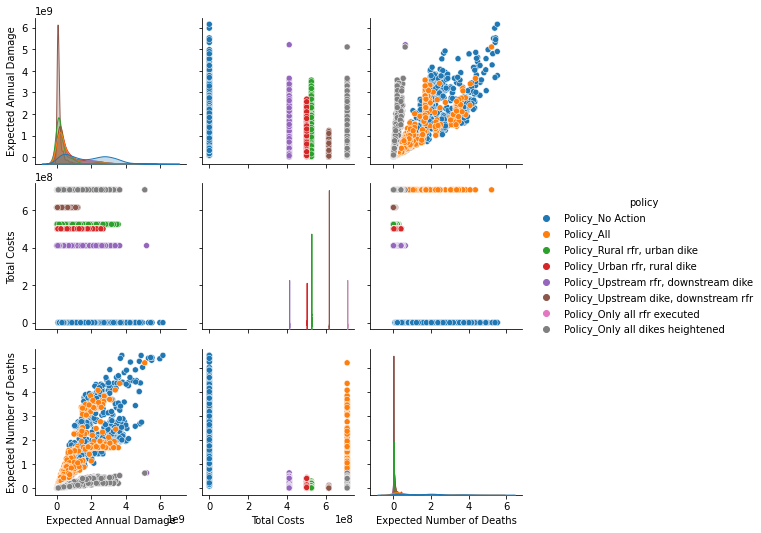

In [10]:
pairplot = sns.pairplot(df, hue='policy',  vars=pairplot_data)
plt.show()

pairplot.savefig("8000_experiments_open_exploration.png")